In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tfkl = tf.keras.layers

In [2]:
def get_data(index, data, max_val, mode):

    # if we want to select data in order for any reason, we'd switch to "not_random" 
    # but we will use random sampling for training
    if mode == "not_random":
        entry = data[index, :]
    else:
        # Randomly selects index from data between 0 and the max index in training data
        rand_index = tf.random.uniform([], minval=0, maxval=max_val, dtype=tf.int32)
        entry = data[rand_index, :]


    # Normalize or prepare data
    geography, gender, year, age, rate = entry[0], entry[1], entry[2], entry[3], entry[4]
    year = (year - 1959) / 60
    age = tf.cast(age, tf.int32)
    geography = tf.cast(geography, tf.int32)
    gender = tf.cast(gender, tf.int32)
    epsilon = 9e-06    # smallest observed rate in training data
    rate = tf.math.log(tf.maximum(rate, epsilon))


    # Reshape each element to scalar
    features = (tf.reshape(year, [1]), tf.reshape(age, [1]),
               tf.reshape(geography, [1]), tf.reshape(gender, [1]))
    rate = tf.reshape(rate, [1])
    return features, rate

In [3]:
def prep_data(data, mode):
    data = tf.convert_to_tensor(data)
    data = tf.cast(data, tf.float32)
    max_val = data.shape[0]


    dataset = tf.data.Dataset.from_tensor_slices(np.arange(10000))


    if mode == "train":
        dataset = dataset.repeat()
    
    else:
        dataset = dataset.repeat(120)
    
    dataset = dataset.map(
        lambda x: get_data(x, data, max_val=max_val, mode=mode), 
                          num_parallel_calls=4)


    dataset = dataset.batch(256)


    # Prefetch to improve performance
    final_data = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


    return final_data

In [4]:
def create_model(geo_dim):
    # defining inputs 
    year = tfkl.Input(shape=(1,), dtype='float32', name='Year')
    age =  tfkl.Input(shape=(1,), dtype='int32', name='Age')
    geography = tfkl.Input(shape=(1,), dtype='int32', name='Geography')
    gender = tfkl.Input(shape=(1,), dtype='int32', name='Gender')

    # defining embedding layers 
    age_embed = tfkl.Embedding(input_dim=100, output_dim=5, name='Age_embed')(age)
    age_embed = tfkl.Flatten()(age_embed)

    gender_embed = tfkl.Embedding(input_dim=2, output_dim=5, name='Gender_embed')(gender)
    gender_embed = tfkl.Flatten()(gender_embed)

    geography_embed = tfkl.Embedding(input_dim=geo_dim, output_dim=5,       
                                     name='Geography_embed')(geography)
    geography_embed = tfkl.Flatten()(geography_embed)

    # create feature vector that concatenates all inputs 
    x = tfkl.Concatenate()([year, age_embed, gender_embed, geography_embed])
    x1 = x

    # setting up hidden layers 
    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Concatenate()([x1, x])
    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)
    
    x = tfkl.Dense(1, name='final')(x)

    # creating the model 
    model = tf.keras.Model(inputs=[year, age, geography, gender], outputs=[x])

    # compiling the model
    model.compile(loss='mse', optimizer='adam')

    return model


In [5]:
def run_deep_model(dataset_train, dataset_test, geo_dim, epochs, steps_per_epoch):

    model = create_model(geo_dim)

    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.25, 
                                                      patience=3, verbose=0, mode="auto", 
                                                      min_delta=1e-8, cooldown=0,        
                                                      min_lr=0.0)]
    history = model.fit(dataset_train, validation_data=dataset_test, 
                        validation_steps=25, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=epochs, verbose=2, callbacks=callbacks)

    tf.keras.backend.clear_session()

    return model 

In [6]:
# load data (adjust path as needed)
training = np.loadtxt('hmd_training.txt')
test = np.loadtxt('hmd_test.txt')

# prep data
train_prepped = prep_data(training, mode="train")
test_prepped = prep_data(test, mode="test")

# get value for the geography dimension
geo_dim = int(max(training[:,0]) + 1)

In [42]:
print(train_prepped
      )

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [17]:
trained_model = run_deep_model(train_prepped, test_prepped, geo_dim,
                                epochs = 20, steps_per_epoch=1400)  

Epoch 1/20
1400/1400 - 10s - 7ms/step - loss: 2.0438 - val_loss: 0.2565 - learning_rate: 0.0010
Epoch 2/20
1400/1400 - 8s - 6ms/step - loss: 0.3340 - val_loss: 0.2771 - learning_rate: 0.0010
Epoch 3/20
1400/1400 - 8s - 6ms/step - loss: 0.2561 - val_loss: 0.2119 - learning_rate: 0.0010
Epoch 4/20
1400/1400 - 8s - 6ms/step - loss: 0.2170 - val_loss: 0.1962 - learning_rate: 0.0010
Epoch 5/20
1400/1400 - 8s - 6ms/step - loss: 0.2002 - val_loss: 0.2625 - learning_rate: 0.0010
Epoch 6/20
1400/1400 - 9s - 6ms/step - loss: 0.1891 - val_loss: 0.2368 - learning_rate: 0.0010
Epoch 7/20
1400/1400 - 8s - 6ms/step - loss: 0.1854 - val_loss: 0.1621 - learning_rate: 0.0010
Epoch 8/20
1400/1400 - 9s - 6ms/step - loss: 0.1758 - val_loss: 0.2099 - learning_rate: 0.0010
Epoch 9/20
1400/1400 - 9s - 6ms/step - loss: 0.1823 - val_loss: 0.1742 - learning_rate: 0.0010
Epoch 10/20
1400/1400 - 9s - 6ms/step - loss: 0.1764 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 11/20
1400/1400 - 9s - 6ms/step - loss: 0.

In [ ]:
test_input_features = (tf.convert_to_tensor((test[:,2] - 1959) / 60,   
                       dtype=tf.float32),  # Year
                       tf.convert_to_tensor(test[:,3], dtype=tf.float32),  # Age
                       tf.convert_to_tensor(test[:,0], dtype=tf.float32),  # Geo
                       tf.convert_to_tensor(test[:,1], dtype=tf.float32))  # Sex

test_predictions = trained_model.predict(test_input_features)


2482/2482 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step


In [19]:
inputs_test = np.delete(test, 4, axis=1)
test_predictions = np.column_stack((inputs_test, test_predictions))

In [25]:
print(test_predictions)

[[ 5.00000000e+01  0.00000000e+00  2.00600000e+03  0.00000000e+00
  -5.52948332e+00]
 [ 5.00000000e+01  1.00000000e+00  2.00600000e+03  0.00000000e+00
  -5.46074200e+00]
 [ 5.00000000e+01  0.00000000e+00  2.00600000e+03  1.00000000e+00
  -8.08326817e+00]
 ...
 [ 8.90000000e+01  1.00000000e+00  2.01500000e+03  9.80000000e+01
  -9.61513162e-01]
 [ 8.90000000e+01  0.00000000e+00  2.01500000e+03  9.90000000e+01
  -1.05368006e+00]
 [ 8.90000000e+01  1.00000000e+00  2.01500000e+03  9.90000000e+01
  -9.32149172e-01]]


In [ ]:
preds_filtered = test_predictions[(test_predictions[:,0] == 50) & # Austrailia
                                    (test_predictions[:,1] == 1) &  # Males
                                    (test_predictions[:,2] == 2015)] 

test_filtered = test[(test[:,0] == 50) & # Austrailia
                        (test[:,1] == 1) &  # Females
                        (test[:,2] == 2015)]  

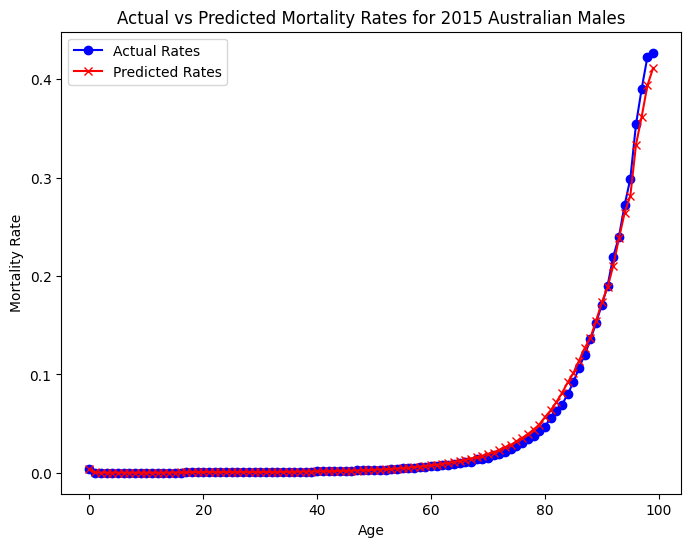

In [36]:
plt.figure(figsize=(8, 6))

plt.plot(test_filtered[:,3], test_filtered[:,4], color='blue', label='Actual Rates', marker='o')
plt.plot(preds_filtered[:,3], np.exp(preds_filtered[:,4]), color='red', label='Predicted Rates', marker='x')
plt.xlabel('Age')
plt.ylabel('Mortality Rate')
plt.title('Actual vs Predicted Mortality Rates for 2015 Australian Males')
plt.legend()
plt.show()


In [23]:
np.load('geos_key.npy')

array([['AK', '0'],
       ['AL', '1'],
       ['AZ', '2'],
       ['AR', '3'],
       ['CA', '4'],
       ['CO', '5'],
       ['CT', '6'],
       ['DE', '7'],
       ['FL', '8'],
       ['GA', '9'],
       ['HI', '10'],
       ['ID', '11'],
       ['IL', '12'],
       ['IN', '13'],
       ['IA', '14'],
       ['KS', '15'],
       ['KY', '16'],
       ['LA', '17'],
       ['ME', '18'],
       ['MD', '19'],
       ['MA', '20'],
       ['MI', '21'],
       ['MN', '22'],
       ['MS', '23'],
       ['MO', '24'],
       ['MT', '25'],
       ['NE', '26'],
       ['NV', '27'],
       ['NH', '28'],
       ['NJ', '29'],
       ['NM', '30'],
       ['NY', '31'],
       ['NC', '32'],
       ['ND', '33'],
       ['OH', '34'],
       ['OK', '35'],
       ['OR', '36'],
       ['PA', '37'],
       ['RI', '38'],
       ['SC', '39'],
       ['SD', '40'],
       ['TN', '41'],
       ['TX', '42'],
       ['UT', '43'],
       ['VT', '44'],
       ['VA', '45'],
       ['WA', '46'],
       ['WV', '47'],
  